# 05wk-1: 깊은신경망 (4) – GPU 사용법, SGD, Softmax와 CrossEntropy

최규빈  
2024-04-01

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/05wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [ ]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-wHAizLm_MYaUweataauffD&si=U5TXo5UgkRGc6a-F >}}

# 2. Imports

In [ ]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import *
import torchvision

# 3. CPU vs GPU

`-` 파이토치에서 GPU를 쓰는 방법을 알아보자. (사실 지금까지 우리는 CPU만
쓰고 있었음)

## A. GPU 사용방법

`-` cpu 연산이 가능한 메모리에 데이터 저장

In [ ]:
torch.manual_seed(43052)
x_cpu = torch.tensor([0.0,0.1,0.2]).reshape(-1,1)
y_cpu = torch.tensor([0.0,0.2,0.4]).reshape(-1,1)
net_cpu = torch.nn.Linear(1,1)

`-` gpu 연산이 가능한 메모리에 데이터 저장

In [ ]:
!nvidia-smi # before

Tue Apr 23 13:50:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.manual_seed(43052)
x_gpu = x_cpu.to("cuda:0")
y_gpu = y_cpu.to("cuda:0")
net_gpu = torch.nn.Linear(1,1).to("cuda:0")

In [ ]:
!nvidia-smi

Tue Apr 23 13:51:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              25W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

> GPU에 메모리를 올리면 GPU메모리가 점유된다! (26MiB -\> 287MiB)

`-` cpu 혹은 gpu 연산이 가능한 메모리에 저장된 값들을 확인

In [ ]:
x_cpu, y_cpu, net_cpu.weight, net_cpu.bias

(tensor([[0.0000],
         [0.1000],
         [0.2000]]),
 tensor([[0.0000],
         [0.2000],
         [0.4000]]),
 Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

In [ ]:
x_gpu, y_gpu, net_gpu.weight, net_gpu.bias #device ='cuda:0'이 눈에 띈다.

(tensor([[0.0000],
         [0.1000],
         [0.2000]], device='cuda:0'),
 tensor([[0.0000],
         [0.2000],
         [0.4000]], device='cuda:0'),
 Parameter containing:
 tensor([[-0.3467]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.8470], device='cuda:0', requires_grad=True))

`-` gpu는 gpu끼리 연산가능하고 cpu는 cpu끼리 연산가능함

(예시1)

In [ ]:
net_cpu(x_cpu) #넷 cpu, data cpu

tensor([[-0.8470],
        [-0.8817],
        [-0.9164]], grad_fn=<AddmmBackward0>)

(예시2)

In [ ]:
net_gpu(x_gpu) #net: gpu and data : gpu

tensor([[-0.8470],
        [-0.8817],
        [-0.9164]], device='cuda:0', grad_fn=<AddmmBackward0>)

(예시3)

In [ ]:
net_cpu(x_gpu) #net : cpu , data : gpu

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

```python
net_gpu(x_cpu.to("cuda:0")) #해결방안
net_gpu.to_cpu(x_cpu)
```

> **강의중 net을 재선언한 이유**
>
> `-` 아래와 같이 `x_cpu` 혹은 `y_cpu`에 `.to("cuda:0")`메소드를 쓸 경우
>
> ``` python
> x_cpu.to("cuda:0")
> y_cpu.to("cuda:0")
> ```
>
> `x_cpu`와 `y_cpu`는 cpu에 그대로 있음.
>
> `-` 그런데 아래와 같이 `net_cpu`에서 `.to("cuda:0")`메소드를 쓸 경우
>
> ``` python
> net_cpu.to("cuda:0")
> ```
>
> `net_cpu` 자체가 gpu에 올라가게 됨.

(예시4)

In [ ]:
net_gpu(x_cpu) # net : gpu , data : cpu

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

(예시5)

In [ ]:
torch.mean((y_cpu-net_cpu(x_cpu))**2) #cpu들로만 이루어 지게끔..

tensor(1.2068, grad_fn=<MeanBackward0>)

(예시6)

In [ ]:
torch.mean((y_gpu-net_gpu(x_gpu))**2) #gpu들로만 이루어 지게끔..

tensor(1.2068, device='cuda:0', grad_fn=<MeanBackward0>)

(예시7)

In [ ]:
torch.mean((y_gpu-net_cpu(x_cpu))**2) #device(cpu,gpu)가 얽힘.. -> 연산 실패

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

(예시8)

In [ ]:
torch.mean((y_cpu-net_gpu(x_gpu))**2) #그냥 다 gpu에서 하자 !

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Chat GPT says.. "이러한 에러 메시지는 PyTorch에서 텐서의 디바이스(device)가 서로 다른 경우 발생하는 문제를 나타냅니다. 각 텐서는 특정한 디바이스(CPU 또는 GPU)에 할당되어야 하며, 연산 시에는 동일한 디바이스에 있는 텐서들끼리만 연산이 가능합니다. 따라서 CPU에 있는 데이터를 GPU에 있는 네트워크로 전달하려고 할 때 이러한 에러가 발생할 수 있습니다."

## B. 시간측정 (예비학습)

In [ ]:
import time

In [ ]:
t1 = time.time()

In [ ]:
t2 = time.time()

In [ ]:
t2-t1

0.4731173515319824

## C. CPU vs GPU (512 nodes)

`-` CPU (512 nodes)

In [ ]:
torch.manual_seed(5)
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,512), #x에 512 개의 variation을 취함 512개의 가중치 ,512개의 편향
    torch.nn.ReLU(), #activation function
    torch.nn.Linear(512,1) #이걸 적절히 가중을 취해서 하나로 뭉침.. #512개의 가중치 , 1개의 편향..
) #아니면 언패킹해서 관찰할 수 있음 ..
loss_fn = torch.nn.MSELoss() # y가 연속형이므로 MSE
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1
    yhat = net(x)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward() #미분.
    # 4
    optimizr.step() #가중치 조정(학습)
    optimizr.zero_grad() #미분값 삭제.
t2 = time.time()
t2-t1

1.4369375705718994

`-` GPU (512 nodes)

In [ ]:
torch.manual_seed(5)
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
).to("cuda:0") #네트워크도 쿠다에
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1
    yhat = net(x)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

1.5274980068206787

-   CPU가 더 빠르다??

## D. CPU vs GPU (20,480 nodes)

`-` CPU (20,480)

In [ ]:
torch.manual_seed(5)
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1
    yhat = net(x)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

11.121367931365967

`-` GPU (20,480)

In [ ]:
torch.manual_seed(5)
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0") #입력값 cuda
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0") #출력값 cuda
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
).to("cuda:0") #네트워크 cuda
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1
    yhat = net(x)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

1.2567863464355469

-   왜 이런 차이가 나는가?
-   연산을 하는 주체는 코어인데 CPU는 수는 적지만 일을 잘하는 코어들을
    가지고 있고 GPU는 일은 못하지만 다수의 코어를 가지고 있기 때문

## E. CPU vs GPU (204,800 nodes)

`-` CPU (204,800)

In [ ]:
torch.manual_seed(5)
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1
    yhat = net(x)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1 #포기..

KeyboardInterrupt: 

CPU 똑똑하지만 혼자..\
GPU 그리 똑똑하진 않지만 여러명이 일을함.. 단순 계산에 강력

`-` GPU (204,800)

In [ ]:
torch.manual_seed(5)
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1
    yhat = net(x)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

4.567237377166748

# 3. “확률적” 경사하강법

## A. 의문: 좀 이상하지 않아요?

`-` 국민상식: GPU 비싸요..
<https://bbs.ruliweb.com/community/board/300143/read/61066881>

-   GPU 메모리 많아봐야 24GB, 그래도 비싸요..
    <http://shop.danawa.com/virtualestimate/?controller=estimateMain&methods=index&marketPlaceSeq=16>
-   GPU 메모리가 80GB일 경우 가격:
    <https://prod.danawa.com/info/?pcode=21458333>

`-` 우리가 분석하는 데이터: 빅데이터..?

In [ ]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps

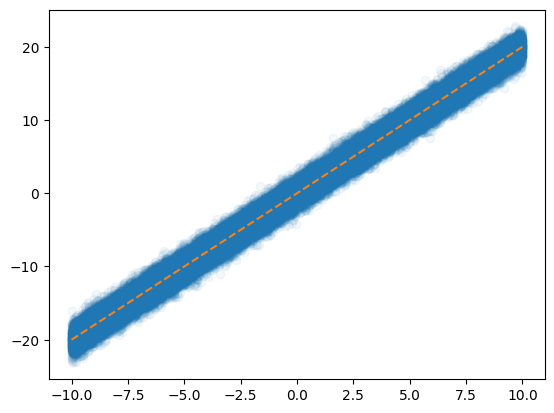

In [ ]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,2*x,'--')

`-` 데이터의 크기가 커지는 순간 `X.to("cuda:0")`, `y.to("cuda:0")` 쓰면
난리나겠는걸?

`-` 데이터를 100개중에 1개만 꼴로만 쓰면 어떨까?

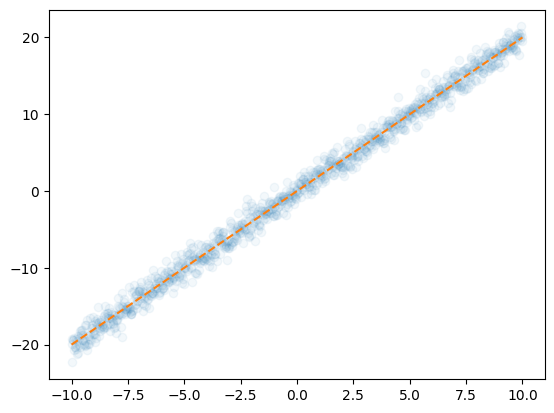

In [ ]:
plt.plot(x[::100],y[::100],'o',alpha=0.05) #인덱싱을 100개 단위로 하는거임 데이터 수 1/100 배..
plt.plot(x,2*x,'--') #이정도면 충분하다!

-   대충 이거만 가지고 적합해도 충분히 정확할것 같은데?

## B. X,y 데이터를 굳이 모두 GPU에 넘겨야 하는가?

`-` 데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면
안되나?

`-` 아래의 알고리즘을 생각해보자.

1.  데이터를 반으로 나눈다.
2.  짝수obs의 x,y 그리고 net의 모든 파라메터를 GPU에 올린다.
3.  yhat, loss, grad, update 수행
4.  짝수obs의 x,y를 GPU메모리에서 내린다. 그리고 홀수obs의 x,y를
    GPU메모리에 올린다.
5.  yhat, loss, grad, update 수행
6.  홀수obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수obs의 x,y를
    GPU메모리에 올린다.
7.  반복

> 이러면 되는거아니야???? —\> 맞아요

## C. 경사하강법, 확률적경사하강법, 미니배치 경사하강법

10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

`# ver1` – 모든 샘플을 이용하여 slope 계산

(epoch 1) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope \to update$

(epoch 2) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope \to update$

…

> 우리가 항상 이렇게 했죠!

`# ver2` – 하나의 샘플만을 이용하여 slope 계산\
 -확률적 경사하강법..-
(epoch 1)

-   $loss=(y_1-w_0-w_1x_1)^2 \to slope \to update$
-   $loss=(y_2-w_0-w_1x_2)^2 \to slope \to update$
-   …
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

(epoch 2)

-   $loss=(y_1-w_0-w_1x_1)^2 \to slope \to update$
-   $loss=(y_2-w_0-w_1x_2)^2 \to slope \to update$
-   …
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

…

`# ver3` – $m (\leq n)$ 개의 샘플을 이용하여 slope 계산\
 -절충안-\
$m=3$이라고 하자.

(epoch 1)

-   $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

(epoch 2)

-   $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

…

## D. 용어의 정리

**옛날**

`-` ver1: gradient descent, batch gradient descent

`-` ver2: stochastic gradient descent

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient
descent

**요즘**

`-` ver1: gradient descent

`-` ver2: stochastic gradient descent with batch size = 1

`-` **ver3: stochastic gradient descent** -
https://www.deeplearningbook.org/contents/optimization.html, 알고리즘
8-1 참고.

## E. Dataset(`ds`), DataLoader(`dl`)

> 취지는 알겠으나, C의 과정을 실제 구현하려면 진짜 힘들것 같아요..
> (입코딩과 손코딩의 차이) –\> 이걸 해결하기 위해서 파이토치에서는
> DataLoader라는 오브젝트를 준비했음!

`-` ds: 섭스크립터블함

In [ ]:
x=torch.tensor(range(10)).float().reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5).reshape(-1,1)
torch.concat([x,y],axis=1) #나란히 볼려고 컨캣.

tensor([[0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 0.],
        [6., 0.],
        [7., 0.],
        [8., 0.],
        [9., 0.]])

In [ ]:
ds=torch.utils.data.TensorDataset(x,y) #데이터 셋
ds

Chat GPT:
torch.utils.data.TensorDataset은 PyTorch에서 제공하는 데이터셋 클래스 중 하나로, 주어진 텐서(Tensor) 데이터를 쉽게 다룰 수 있도록 도와주는 클래스입니다. 이 클래스를 사용하여 텐서 데이터를 간편하게 데이터셋으로 변환하고, 데이터 로더(DataLoader)에 입력할 수 있습니다.

TensorDataset 객체를 생성할 때는 주로 입력 데이터와 레이블(타겟) 데이터를 함께 사용합니다. 위의 코드에서 x와 y는 텐서 데이터로, 각각 입력과 해당하는 레이블을 나타냅니다.

x: 입력 데이터를 나타내는 텐서
y: 입력 데이터에 대응하는 레이블(타겟)을 나타내는 텐서
TensorDataset은 이러한 x와 y를 하나의 데이터셋으로 묶어주는 역할을 합니다. 즉, TensorDataset 객체는 텐서 데이터의 쌍(pair)을 요소로 갖는 데이터셋을 나타냅니다. 이 데이터셋은 각각의 텐서 데이터에 대해 독립적으로 접근하고 데이터를 사용할 수 있는 인터페이스를 제공합니다.

TensorDataset 객체를 생성한 후에는 이를 데이터 로더(DataLoader)에 입력하여 미니배치(mini-batch) 단위로 데이터를 로드하고 학습에 활용할 수 있습니다. 데이터셋을 미니배치로 나누어 학습 과정에서 사용할 수 있도록 하는 것이 TensorDataset의 역할 중 하나입니다.

간단히 말해, TensorDataset은 PyTorch에서 텐서 데이터를 다루기 쉽도록 추상화된 데이터셋 클래스로, 데이터를 관리하고 학습에 활용할 수 있는 구조를 제공합니다.

**요약:** 독특한 인덱싱을 활용하며 입출력 데이터를 순서에 맞게 짝을 맺어주고 미니배치 학습에 사용하기 좋은 객체이다.

In [ ]:
dir(ds)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'tensors']

In [ ]:
ds.tensors
# 생긴건 ds.tensors = (x,y) 임

(tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [ ]:
(x,y) #ds의 텐서를 찍으면 똑같이 생겼음.

(tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [ ]:
ds[0],(x,y)[0] # (x,y) 튜플자체는 아님.. 인덱싱이 다르게 동작

((tensor([0.]), tensor([1.])),
 tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]))

> **Note**
>
> 여기서 제가 `__iter__` 가 숨겨져 있는 오브젝트일 경우만 `for`문이
> 동작한다고 설명 했는데요, `__getitem__`이 있는 경우도 동작한다고
> 합니다. **제가 잘못 알고 있었어요. 혼란을 드려 죄송합니다**.
>
> -   그래도 `dl`은 for 를 돌리기위해서 만든 오브젝트라는 설명은 맞는
>     설명입니다.
> -   `ds`역시 독특한 방식의 인덱싱을 지원하도록 한 오브젝트라는 설명도
>     맞는 설명입니다.

`-` dl: 섭스크립터블하지 않지만 이터러블함

In [ ]:
dl=torch.utils.data.DataLoader(ds,batch_size=3) #배치 사이즈 지정
#set(dir(dl)) & {'__iter__'}

In [ ]:
dir(dl)[:10]

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__']

In [ ]:
for x_batch, y_batch in dl:
  print(x_batch) #3개씩 끊겨 나옴,

tensor([[0.],
        [1.],
        [2.]])
tensor([[3.],
        [4.],
        [5.]])
tensor([[6.],
        [7.],
        [8.]])
tensor([[9.]])


In [ ]:
for xi,yi in dl:
    print(f"x_batch:{xi.tolist()} \t y_batch:{yi.tolist()}") #fstring 아래에 다시 공부

# 새치기 시키고 싶은 애를 {} 로 감싸는거임
# 마지막관측치는 뭔데 단독으로 업데이트하냐?? –> shuffle
# True 같이 자잘한 옵션도 있음..

x_batch:[[0.0], [1.0], [2.0]] 	 y_batch:[[1.0], [1.0], [1.0]]
x_batch:[[3.0], [4.0], [5.0]] 	 y_batch:[[1.0], [1.0], [0.0]]
x_batch:[[6.0], [7.0], [8.0]] 	 y_batch:[[0.0], [0.0], [0.0]]
x_batch:[[9.0]] 	 y_batch:[[0.0]]


`-` 마지막관측치는 뭔데 단독으로 업데이트하냐?? –\> shuffle True 같이
자잘한 옵션도 있음..

In [ ]:
dl = torch.utils.data.DataLoader(ds,batch_size=3,shuffle=True) #돌 때(epoch)마다 단독으로 업데이트 되는 친구가 달라짐
for xi,yi in dl: #순서쌍은 맞춰진 채로 shuffle 되는거임.. 어찌보면 당연,,, 달라지면 어떻게 학습할건데..
    print(f'x_batch={xi.tolist()} \t y_batch={yi.tolist()}')

x_batch=[[9.0], [7.0], [5.0]] 	 y_batch=[[0.0], [0.0], [0.0]]
x_batch=[[4.0], [6.0], [3.0]] 	 y_batch=[[1.0], [0.0], [1.0]]
x_batch=[[2.0], [1.0], [0.0]] 	 y_batch=[[1.0], [1.0], [1.0]]
x_batch=[[8.0]] 	 y_batch=[[0.0]]


## F. ds, dl을 이용한 MNIST 구현

`-` 목표: 확률적경사하강법과 그냥 경사하강법의 성능을 “동일 반복횟수”로
비교해보자.

-   batch_size = 2048로 설정할것

`-` 그냥 경사하강법 – 미니배치 안쓰는 학습, 우리가 맨날하는 그거

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255 #0부터 255의 integer 자료형인데, 0~1 float으로 scaling? 맞.
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid() #1. 시그모이드 있다
)
loss_fn = torch.nn.BCELoss() #2. BCE로스로 받는다.
optimizr = torch.optim.SGD(net.parameters())
## Step3: fit
for epoc in range(700):
    # step1
    yhat = net(X)
    # step2
    loss = loss_fn(yhat,y)
    # step3
    loss.backward()
    # step4
    optimizr.step()
    optimizr.zero_grad()
## Step4: Predict
((yhat > 0.5)*1.0 ==  y).float().mean()

tensor(0.9953)

`-` “확률적”경사하강법 – 미니배치 쓰는 학습

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y) #차이점1 , 대응 하는 짝을 만들어주고
dl = torch.utils.data.DataLoader(ds,batch_size=2048) #차이점2 그룹을 나누어서 학습할 때 이터러블하게끔 만들어줌.
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())
# ## Step3: fit
for epoc in range(100): #100
    for xi,yi in dl: #7 따라서 100*7 = 700
        # step1
        #yihat = net(xi)
        # step2
        loss = loss_fn(net(xi),yi) #걍 귀찮으니까 생략한거임!
        # step3
        loss.backward()
        # step4
        optimizr.step()
        optimizr.zero_grad()
# ## Step4: Predict
((net(X) > 0.5)*1.0 ==  y).float().mean()

tensor(0.9931)

`-` GPU를 활용하는 “확률적”경사하강법 – 실제적으로는 이게 최종알고리즘

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()]) #흑백이미지임.
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()#시그모이드가 있으니깐
).to("cuda:0")
loss_fn = torch.nn.BCELoss() #BCE 로스로 받는게 적절~
optimizr = torch.optim.SGD(net.parameters())
## Step3: fit
for epoc in range(100):
    for xi,yi in dl: #dl은 7개임
        # step1
        # step2
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        # step3
        loss.backward()
        # step4
        optimizr.step()
        optimizr.zero_grad()
# ## Step4: Predict
net.to("cpu")
((net(X) > 0.5)*1.0 ==  y).float().mean() #왜 생략하셨징..

tensor(0.9931)

# 4. 다중클래스 분류

## A. 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야
한다면?

***일반적인 개념***

-   손실함수: BCE loss $\to$ Cross Entropy loss
-   마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k)
-   **마지막층의 활성화: sig $\to$ softmax**

***파이토치 한정***

-   **y의형태: (n,) vector + int형 // (n,k) one-hot encoded matrix +
    float형**
-   손실함수: torch.nn.BCEWithLogitsLoss, $\to$
    torch.nn.CrossEntropyLoss
-   마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k)
-   **마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의
    활성화가 포함)**

## B. 실습: 3개의 클래스를 구분

`-` 정리된 코드1: 통계잘하는데 파이토치 못쓰는 사람의 코드

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float() #이게 흠 인거임.. 사실 안해도 알아서 학습할 때 인코딩해줌
#원핫 인코딩 해놓고... float으로 변경.. 이게 존나 짜침.. 왜 float이면 원 핫 인코딩 안받아주는데?

In [ ]:
y # one-hot encoding

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3), #y의 꼬라지.. 피쳐가 3개니까 3으로 받아야 함..
#    torch.nn.Softmax() #예전같았으면 걸어줬겠지만.. 생략하고 로스펑션에 포함된 기능으로 대체
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: 적합
for epoc in range(100):
    ## step1
    netout = net(X) #사실 얘에 소프트 맥스까지 씌워주는게 맞음..
    #그래서 네트워크 아웃풋으로 저장한거임.
    ## step2
    loss = loss_fn(netout,y) #알아서 소프트맥스 씌워드립니다.
    ## step3
    loss.backward()
    ## step4
    optimizr.step()
    optimizr.zero_grad()

## Step4: 적합 (혹은 적합결과확인)
(netout.argmax(axis=1) == y.argmax(axis=1)).float().mean() #argmax는 큰 원소의 인덱스를 반환..
#열 방향으로 긁음.. axis = 1 을 해석하는 장윤서의 방법..

tensor(0.9827)

In [ ]:
netout #꼬라지를 보자
#0과 1사이로 떨어져 있지 않다.. 선형 변환만 된 놈들

tensor([[ 4.7686, -6.5841, -0.2860],
        [ 3.2314, -5.7069,  0.4093],
        [ 3.9514, -5.1752, -0.3602],
        ...,
        [-0.7029, -1.9778,  1.8932],
        [-1.3871, -4.7801,  6.9982],
        [-2.6009, -0.8733,  2.9371]], grad_fn=<AddmmBackward0>)

In [ ]:
#torch.nn.Softmax()(netout) #이렇게 하거나
softmax = torch.nn.Softmax()
softmax(netout) #으로 하거나.. 열을 한 행을 합치면 1이 나온다.. 즉 숫자가 가장 높은 놈으로 예측을 하겠다는

tensor([[9.9365e-01, 1.1663e-05, 6.3394e-03],
        [9.4374e-01, 1.2388e-04, 5.6134e-02],
        [9.8666e-01, 1.0728e-04, 1.3234e-02],
        ...,
        [6.8068e-02, 1.9023e-02, 9.1291e-01],
        [2.2815e-04, 7.6675e-06, 9.9976e-01],
        [3.8341e-03, 2.1576e-02, 9.7459e-01]], grad_fn=<SoftmaxBackward0>)

`-` 정리된 코드2: 파이토치를 잘하는 사람의 코드

차이는 원 핫 인코딩이 그냥 적합중에 알아서 된다는 것 정도?

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
#y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2)) #원 핫 인코딩이 아니라 라벨아 따라 그냥 숫자 부여

In [ ]:
y , y.shape #그냥 리스트와 같다..
#벡터를 입력시키면 알아서 파이토치가 원 핫 인코딩을 진행해줌..

(tensor([0, 0, 0,  ..., 2, 2, 2]), torch.Size([18623]))

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
#y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
#    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: 적합
for epoc in range(100):
    ## step1
    netout = net(X)
    ## step2
    loss = loss_fn(netout,y)
    ## step3
    loss.backward()
    ## step4
    optimizr.step()
    optimizr.zero_grad()
## Step4: 적합 (혹은 적합결과확인)
(netout.argmax(axis=1) == y).float().mean()

tensor(0.9827)

**궁금점:** 왜 이미지의 색상값을 0 ~ 1 사이의 float으로 보나요?\

MNIST 데이터셋에서 이미지 데이터는 각 픽셀의 밝기를 나타내는 정수 값 범위가 0부터 255까지입니다. 하지만 딥러닝 모델은 일반적으로 입력 데이터를 0에서 1 또는 -1에서 1 사이의 범위로 정규화하여 학습합니다. 이렇게 정규화하는 이유는 다음과 같습니다:

`1:`수렴 속도 향상:\
입력 데이터를 정규화하면 각 픽셀의 값이 0과 1 사이로 제한되므로 수치적으로 안정적인 학습이 가능합니다.
네트워크의 가중치 업데이트가 수렴 속도를 높일 수 있습니다.\
`2:`Gradient 계산의 안정성:\
정규화된 입력 데이터는 기울기(gradient)를 계산할 때 오버플로우(overflow)나 언더플로우(underflow)를 방지합니다.
특히 Sigmoid나 Tanh와 같은 활성화 함수를 사용할 때 입력 값의 범위가 제한되면 활성화 함수의 출력이 효과적으로 조절됩니다.\
`3:`모델 일반화 향상:\
입력 데이터의 정규화는 모델의 일반화 성능을 향상시킬 수 있습니다.
네트워크가 입력 데이터의 통계적 특성에 덜 민감해지고 다양한 데이터에서 더 좋은 성능을 발휘할 수 있습니다.\
`4:`네트워크 구조의 통일성:\
다양한 네트워크 구조에 대해 입력 데이터의 범위가 일정하게 유지되면 모델을 쉽게 비교하고 결합할 수 있습니다.
따라서 MNIST 이미지 데이터를 0부터 255의 정수 값으로 나누어 0에서 1 사이의 실수 값으로 변환하는 것은 일반적인 딥러닝 모델 학습의 관행이며, 학습 과정을 안정화하고 최적화하는 데 도움이 됩니다.

In [ ]:
(netout.argmax(axis=1) == y).float().mean() #바로 y랑 비교할 수 있다..!!

tensor(0.9827)

-   완전같은코드임

## C. Softmax

`-` 눈치: softmax를 쓰기 직전의 숫자들은 (n,k)꼴로 되어있음. 각
observation 마다 k개의 숫자가 있는데, 그중에서 유난히 큰 하나의 숫자가
있음.

In [ ]:
net(X)

tensor([[ 2.5498, -3.8855,  0.4495],
        [ 5.0282, -6.8619,  0.1967],
        [ 5.5111, -6.4348, -1.6990],
        ...,
        [-1.2327, -3.8033,  3.2577],
        [-2.2154, -0.9332,  2.0654],
        [-2.2842, -1.4811,  4.0268]], grad_fn=<AddmmBackward0>)

In [ ]:
y

tensor([0, 0, 0,  ..., 2, 2, 2])

`-` 수식

-   $\text{sig}(u)=\frac{e^u}{1+e^u}$
-   $\text{softmax}({\boldsymbol u})=\text{softmax}([u_1,u_2,\dots,u_k])=\big[ \frac{e^{u_1}}{e^{u_1}+\dots e^{u_k}},\dots,\frac{e^{u_k}}{e^{u_1}+\dots e^{u_k}}\big]$

`-` torch.nn.Softmax() 손계산

(예시1) – 잘못계산

In [ ]:
softmax = torch.nn.Softmax(dim=0) #함수에 디멘젼이라는 옵션,.? #행단위로 소프트맥스를 걸어버린것이었다.

In [ ]:
netout = torch.tensor([[-2.0,-2.0,0.0],
                        [3.14,3.14,3.14],
                        [0.0,0.0,2.0],
                        [2.0,2.0,4.0],
                        [0.0,0.0,0.0]])
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
softmax(netout) #한 열씩 아래로 긁으면서 합치면 1임

tensor([[0.0041, 0.0041, 0.0115],
        [0.7081, 0.7081, 0.2653],
        [0.0306, 0.0306, 0.0848],
        [0.2265, 0.2265, 0.6269],
        [0.0306, 0.0306, 0.0115]])

(예시2) – 이게 맞게 계산되는 것임

In [ ]:
softmax = torch.nn.Softmax(dim=1) #이건 그냥 필수 암기급 사항..

In [ ]:
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
softmax(netout)

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시3) – 차원을 명시안하면 맞게 계산해주고 경고 줌

In [ ]:
softmax = torch.nn.Softmax()

In [ ]:
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
softmax(netout) #직관적으로 열단위로 feature를 받는다.

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시4) – 진짜 손계산

In [ ]:
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
torch.exp(netout)

tensor([[ 0.1353,  0.1353,  1.0000],
        [23.1039, 23.1039, 23.1039],
        [ 1.0000,  1.0000,  7.3891],
        [ 7.3891,  7.3891, 54.5981],
        [ 1.0000,  1.0000,  1.0000]])

In [ ]:
0.1353/(0.1353 + 0.1353 + 1.0000), 0.1353/(0.1353 + 0.1353 + 1.0000), 1.0000/(0.1353 + 0.1353 + 1.0000) # 첫 obs

(0.10648512513773022, 0.10648512513773022, 0.7870297497245397)

In [ ]:
torch.exp(netout[1])/torch.exp(netout[1]).sum() # 두번째 obs

tensor([0.3333, 0.3333, 0.3333])

## D. CrossEntropyLoss

`-` 수식

***`# 2개의 카테고리`***

`-` 예제1: BCELoss vs BCEWithLogisticLoss

In [ ]:
y = torch.tensor([0,0,1]).reshape(-1,1).float()
netout = torch.tensor([-1, 0, 1]).reshape(-1,1).float()
y,netout

(tensor([[0.],
         [0.],
         [1.]]),
 tensor([[-1.],
         [ 0.],
         [ 1.]]))

In [ ]:
# 계산방법1: 공식암기
sig = torch.nn.Sigmoid()
yhat = sig(netout) #우리가 예측하고자 한 것.
- torch.sum(torch.log(yhat)*y + torch.log(1-yhat)*(1-y))/3 #그냥 공식이 이러함.

tensor(0.4399)

In [ ]:
# 계산방법2: torch.nn.BCELoss() 이용
sig = torch.nn.Sigmoid()
yhat = sig(netout)
loss_fn = torch.nn.BCELoss()
loss_fn(yhat,y) #같고

tensor(0.4399)

In [ ]:
# 계산방법3: torch.nn.BCEWithLogitsLoss() 이용
loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn(netout,y) #같다

tensor(0.4399)

`-` 예제2: BCEWithLogisticLoss vs CrossEntropyLoss

In [ ]:
sig(netout) #1일 확률

tensor([[0.2689],
        [0.5000],
        [0.7311]])

In [ ]:
torch.concat([sig(netout),1-sig(netout)],axis=1) #시그모이드를 나란히 붙여서 합이 1로 되게끔 조정한 것. 두개의 카테고리.

tensor([[0.2689, 0.7311],
        [0.5000, 0.5000],
        [0.7311, 0.2689]])

In [ ]:
netout = torch.tensor([[3,2],[2,2],[5,6]]).float() #바꿔보자 소프트 맥스의 함수가 exponential의 특수한 연산이라.. 성립할듯
y = torch.tensor([[1,0],[1,0],[0,1]]).float()
y, netout  #,netout[:,[1]]-netout[:,[0]]

(tensor([[1., 0.],
         [1., 0.],
         [0., 1.]]),
 tensor([[3., 2.],
         [2., 2.],
         [5., 6.]]))

In [ ]:
np.exp(3)/(np.exp(3) + np.exp(2)) , np.exp(1)/(np.exp(0) + np.exp(1))

(0.7310585786300048, 0.7310585786300049)

In [ ]:
softmax(netout) #... 근데 왜 같냐? 위의 수식 관찰.. 차이만 일정하면 똑같음.. softmax 함수의 구조

tensor([[0.7311, 0.2689],
        [0.5000, 0.5000],
        [0.2689, 0.7311]])

In [ ]:
# 계산방법1: 공식암기
-torch.sum(torch.log(softmax(netout))*y)/3

tensor(0.4399)

In [ ]:
y #원 핫 인코딩

tensor([[1., 0.],
        [1., 0.],
        [0., 1.]])

In [ ]:
# 계산방법2: torch.nn.CrossEntropyLoss() 이용 + y는 one-hot으로 정리
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

tensor(0.4399)

In [ ]:
y = torch.tensor([0,0,1]) #원핫을 취하지 않은, label을 의미하는 정수 값

In [ ]:
# 계산방법3: torch.nn.CrossEntropyLoss() 이용 + y는 0,1 로 정리
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y) #알아서 원핫 돌려줌

tensor(0.4399)

`#`

***`# 3개의 카테고리`***

In [ ]:
y = torch.tensor([2,1,2,2,0])
y_onehot = torch.nn.functional.one_hot(y)
netout = torch.tensor(
    [[-2.0000, -2.0000,  0.0000],
     [ 3.1400,  3.1400,  3.1400],
     [ 0.0000,  0.0000,  2.0000],
     [ 2.0000,  2.0000,  4.0000],
     [ 0.0000,  0.0000,  0.0000]]
)
y,y_onehot

(tensor([2, 1, 2, 2, 0]),
 tensor([[0, 0, 1],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [1, 0, 0]]))

In [ ]:
## 방법1 -- 추천X
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y_onehot.float())

tensor(0.5832)

In [ ]:
## 방법2 -- 추천O
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y) #원핫 인코딩 안해도 다 구해준다..

tensor(0.5832)

In [ ]:
## 방법3 -- 공식.. (이걸 쓰는사람은 없겠지?)
softmax = torch.nn.Softmax()
#loss_fn = torch.nn.CrossEntropyLoss()
- torch.sum(torch.log(softmax(netout))*y_onehot)/5 #직접구하는 멋쟁이가.... 있을까....

tensor(0.5832)

`#`

`-` 계산하는 공식을 아는것도 중요한데 torch.nn.CrossEntropyLoss() 에는
softmax 활성화함수가 이미 포함되어 있다는 것을 확인하는 것이 더 중요함.

`-` torch.nn.CrossEntropyLoss() 는 사실 torch.nn.CEWithSoftmaxLoss()
정도로 바꾸는 것이 더 말이 되는 것 같다.

## E. Minor Topic: 이진분류와 CrossEntropy

`-` 2개의 클래스일경우에도 CrossEntropy를 쓸 수 있지 않을까?

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)) # 정수로 -> 알아서 onehot encoding
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit
for epoc in range(70):
    ## 1
    ## 2
    loss= loss_fn(net(X),y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()
## Step4: Predict
softmax = torch.nn.Softmax()
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9983)

**노드 그래프 저번시간에 그려준걸 잘 보고 가중치가 몇 by 몇인지 잘 체크**

`-` 이진분류문제 = “y=0 or y=1” 을 맞추는 문제 = 성공과 실패를 맞추는
문제 = 성공확률과 실패확률을 추정하는 문제

`-` softmax, sigmoid

-   softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는
    실패확률과 성공확률을 둘다 추정한다.
-   sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만
    추정한다.

`-` 그런데 “실패확률=1-성공확률” 이므로 사실상 둘은 같은걸 추정하는
셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까)

`-` 즉 아래는 같은 표현력을 가진 모형이다.

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-20-8wk-1_files/figure-html/cell-53-output-1.svg)

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-20-8wk-1_files/figure-html/cell-54-output-1.svg)

`-` 둘은 같은 표현력을 가진 모형인데 학습할 파라메터는 sigmoid의 경우가
더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고 효과는 동일하다는
말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를 써야함.

-   softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이
    불가능한 반면 softmax는 확장이 용이하다는 장점이 있음.

## F. 정리

`-` 결론

1.  소프트맥스는 시그모이드의 확장이다.
2.  클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고
    클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를
    사용해야 한다.

`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax,
CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (그냥 좀
비효율적인 느낌이 드는 것 뿐임. 흑백이미지를 칼라잉크로 출력하는 느낌)

***참고***

|               $y$               |            분포가정             | 마지막층의 활성화함수 |   손실함수    |
|:-------------------------------:|:-------------------------------:|:---------------------:|:-------------:|
|     3.45, 4.43, … (연속형)      |            정규분포             |  None (or Identity)   |      MSE      |
|             0 or 1              | 이항분포 with $n=1$ (=베르누이) |        Sigmoid        |      BCE      |
| \[0,0,1\], \[0,1,0\], \[1,0,0\] |       다항분포 with $n=1$       |        Softmax        | Cross Entropy |



# 5. HW

아래와 같은 자료가 있다.

In [ ]:
## Step1: 데이터준비
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))

`(1)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   손실함수를 `torch.nn.BCELoss()`로 설정하라.
-   epoch = 325로 설정하라.


In [ ]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)).reshape(-1,1).float()

net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() #얘는 플롯을 받음... 그래서 y벡터가 float으로 들어와줘야 하는거임..
optimizr = torch.optim.SGD(net.parameters())

for epoc in range(325):
  #step1
  yhat = net(X)
  #step2
  loss = loss_fn(yhat,y)
  #step3
  loss.backward()
  #step4
  optimizr.step()
  optimizr.zero_grad()

((yhat > 0.5)*1.0 == y).float().mean()

tensor(0.9952)

`(2)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   손실함수를 `torch.nn.BCEWithLogitsLoss()`로 설정하라.
-   epoch = 325로 설정하라.

In [ ]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.SGD(net.parameters())

for epoc in range(325):
  #step1
  yhat = net(X)
  #step2
  loss = loss_fn(yhat,y)
  #step3
  loss.backward()
  #step4
  optimizr.step()
  optimizr.zero_grad()

((sig(yhat) > 0.5)*1.0 == y).float().mean()

tensor(0.9874)

In [ ]:
((sig(yhat) > 0.5)*1.0 == y).float().mean()

tensor(0.9874)

`(3)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   y를 one_hot 인코딩하라.
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   epoch = 325로 설정하라.

**hint** 원핫인코딩을 위해 아래의 함수를 사용하라.

In [ ]:
y, torch.nn.functional.one_hot(y)

(tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([[1, 0],
         [1, 0],
         [1, 0],
         ...,
         [0, 1],
         [0, 1],
         [0, 1]]))

In [ ]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)) #float 취하면 원핫인코딩 안됨
y = torch.nn.functional.one_hot(y).float() #근데 또 인코딩하고 float 해줘야함 잘 파악했었군.. 과거의 나..

net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.SGD(net.parameters())

for epoc in range(325):
  #step1
  netout = net(X)
  #step2
  loss = loss_fn(netout,y)
  #step3
  loss.backward()
  #step4
  optimizr.step()
  optimizr.zero_grad()

(netout.argmax(axis=1) == y.argmax(axis=1)).float().mean()

tensor(0.9938)

`(4)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   y를 (one-hot 인코딩 하지 않고) lenght-$n$인 벡터로 유지하라.
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   epoch = 325로 설정하라.



In [ ]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))

net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.SGD(net.parameters())

for epoc in range(325):
  #step1
  netout = net(X)
  #step2
  loss = loss_fn(netout,y)
  #step3
  loss.backward()
  #step4
  optimizr.step()
  optimizr.zero_grad()

(netout.argmax(axis=1) == y).float().mean()

tensor(0.9956)

`(5)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   batch_size = 1024 로 설정한뒤 mini_batch를 이용한 학습을 하라.
-   y를 (one-hot 인코딩 하지 않고) lenght-$n$인 벡터로 유지하라.  
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   총 iteration 수가 325가 되도록 적절하게 epoch 을 설정하라.



In [ ]:
325/13

25.0

In [ ]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds ,batch_size=1024) #배치 사이즈 지정..


net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.SGD(net.parameters())

for epoc in range(25):  #325/13 = 25
  for xi,yi in dl:
    #step1
    #step2
    loss = loss_fn(net(xi),yi)
    #step3
    loss.backward()
    #step4
    optimizr.step()
    optimizr.zero_grad()

(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9906)

`(6)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   batch_size = 512 로 설정한뒤 mini_batch를 이용한 학습을 하라.
-   y를 (one-hot 인코딩 하지 않고) lenght-$n$인 벡터로 유지하라.
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   총 iteration 수가 325가 되도록 적절하게 epoch 을 설정하라.
-   GPU를 활용하여 학습하라.

In [ ]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds ,batch_size=512) #배치 사이즈 지정..


net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.SGD(net.parameters())

for epoc in range(13):  #325/25 = 13
  for xi,yi in dl:
    #step1
    #step2
    loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
    #step3
    loss.backward()
    #step4
    optimizr.step()
    optimizr.zero_grad()

net.to("cpu")
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9917)

In [ ]:
12655/512 #얼핏 25

24.716796875

In [ ]:
325/25

13.0